## Part 1: Exploratory Analysis
**Keshav Bhargava**

In [152]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

df = pd.read_csv('project1.csv')

print("Dataset Shape (rows, columns):", df.shape)
print("Total number of data points:", df.size)

Dataset Shape (rows, columns): (131165, 12)
Total number of data points: 1573980


In [153]:
print(df.info())
# I noticed that Name, Outcome Type, and Outcome Subtype 
# have missing values
# Additionally, there needs to be type conversions for:
# DateTime, MonthYear, Date of Birth -> datetime
# Age upon Outcome -> numeric (days)
# Outcome Type, Outcome Subtype, Animal Type, Sex upon Outcome,
# Breed, Color -> categorical
num_duplicates = df.duplicated().sum()
print("Number of duplicate rows:", num_duplicates)
if num_duplicates > 0:
    df = df.drop_duplicates()
    print("Duplicates removed.")
else:
    print("No duplicates found.")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131165 entries, 0 to 131164
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Animal ID         131165 non-null  object
 1   Date of Birth     131165 non-null  object
 2   Name              93658 non-null   object
 3   DateTime          131165 non-null  object
 4   MonthYear         131165 non-null  object
 5   Outcome Type      131125 non-null  object
 6   Outcome Subtype   65810 non-null   object
 7   Animal Type       131165 non-null  object
 8   Sex upon Outcome  131165 non-null  object
 9   Age upon Outcome  131165 non-null  object
 10  Breed             131165 non-null  object
 11  Color             131165 non-null  object
dtypes: object(12)
memory usage: 12.0+ MB
None
Number of duplicate rows: 17
Duplicates removed.


In [154]:
print("Missing Data Analysis:")
amt_missing = df.isnull().sum()
print(amt_missing)
# I decided to fill missing values as follows:
# Name: fill with 'Unknown' (indicating no name provided)
# Outcome Type: fill with mode (most common outcome)
# Outcome Subtype: fill with mode (most common subtype)
fill_map = {
    'Name': 'Unknown',
    'Outcome Type': df['Outcome Type'].mode().iloc[0],
    'Outcome Subtype': df['Outcome Subtype'].mode().iloc[0],
}

df = df.fillna(value=fill_map)

print("Missing values after treatment:")
print(df.isnull().sum())

Missing Data Analysis:
Animal ID               0
Date of Birth           0
Name                37503
DateTime                0
MonthYear               0
Outcome Type           40
Outcome Subtype     65346
Animal Type             0
Sex upon Outcome        0
Age upon Outcome        0
Breed                   0
Color                   0
dtype: int64
Missing values after treatment:
Animal ID           0
Date of Birth       0
Name                0
DateTime            0
MonthYear           0
Outcome Type        0
Outcome Subtype     0
Animal Type         0
Sex upon Outcome    0
Age upon Outcome    0
Breed               0
Color               0
dtype: int64


In [155]:
# I felt that 'Animal ID' and 'Name' are not relevant for prediction
# so I will drop them
irrelevant_columns = ['Animal ID', 'Name']
df = df.drop(columns=irrelevant_columns, errors='ignore')
print(f"✓ Irrelevant columns dropped: {irrelevant_columns}")

✓ Irrelevant columns dropped: ['Animal ID', 'Name']


In [156]:
# This is the bulk of all the type conversions
# Convert date columns to datetime
df['DateTime'] = pd.to_datetime(df['DateTime'], format='mixed', errors='coerce', utc=True).dt.tz_localize(None)
df['MonthYear'] = pd.to_datetime(df['MonthYear'].astype(str), format='%b-%y', errors='coerce')
df['Date of Birth'] = pd.to_datetime(df['Date of Birth'], format='mixed', errors='coerce', utc=True).dt.tz_localize(None)

# Convert 'Age upon Outcome' to numeric days
def convert_age_to_days_basic(age_str):
	if pd.isna(age_str):
		return np.nan
	parts = str(age_str).replace(',', ' ').split()
	if len(parts) < 2:
		return np.nan
	try:
		num = float(parts[0])
	except Exception:
		return np.nan
	unit = parts[1].lower()
	if 'day' in unit:
		return num
	if 'week' in unit:
		return num * 7
	if 'month' in unit:
		return num * 30
	if 'year' in unit:
		return num * 365
	return np.nan

df['Age upon Outcome'] = df['Age upon Outcome'].map(convert_age_to_days_basic).astype('float64')

# Cast remaining object columns (excluding dates) to category
date_cols = ['DateTime', 'MonthYear', 'Date of Birth']
object_cols = [c for c in df.columns if df[c].dtype == 'object' and c not in date_cols]
df[object_cols] = df[object_cols].astype('category')
print(f"✓ Converted {len(object_cols)} columns to 'category' dtype: {object_cols}")


✓ Converted 6 columns to 'category' dtype: ['Outcome Type', 'Outcome Subtype', 'Animal Type', 'Sex upon Outcome', 'Breed', 'Color']


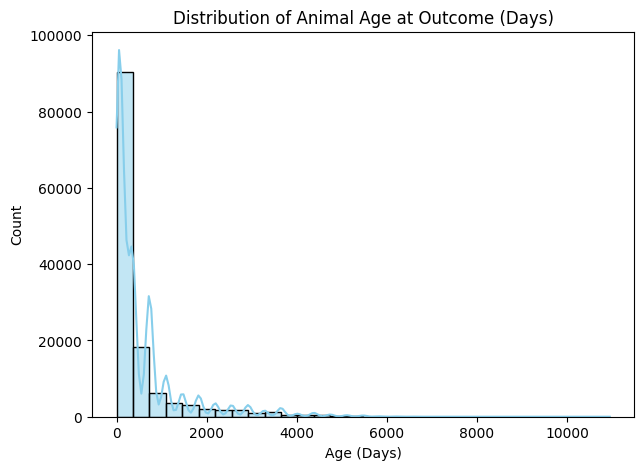

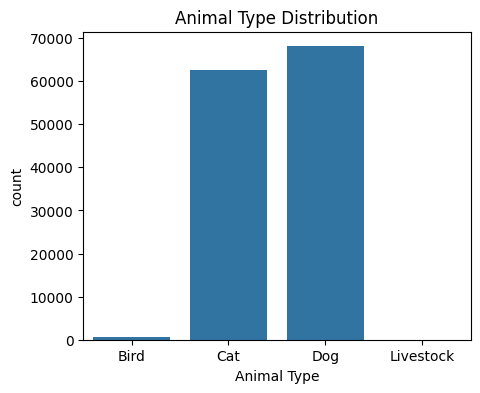

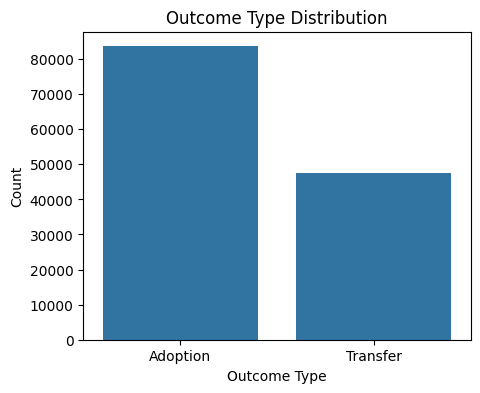

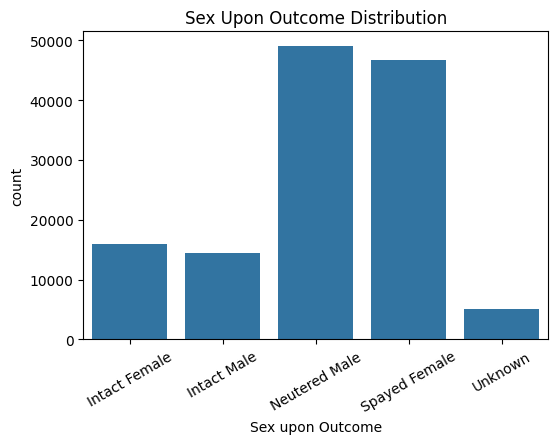

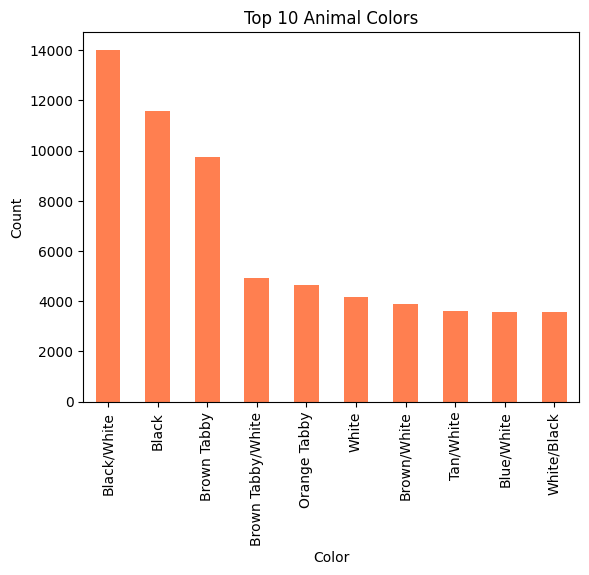

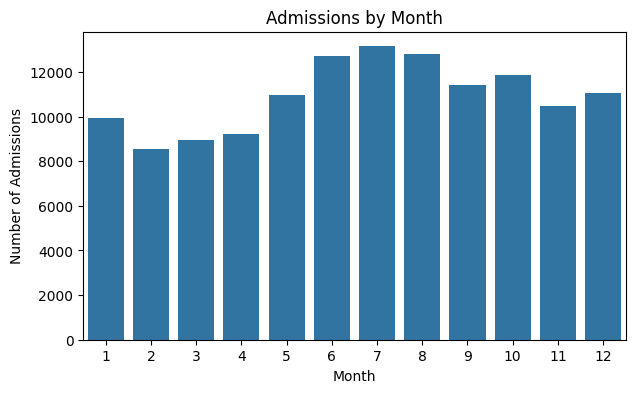

In [157]:
# Exploratory Data Analysis (EDA)
# Distribution of Age upon Outcome
plt.figure(figsize=(7,5))
sns.histplot(df['Age upon Outcome'], bins=30, kde=True, color='skyblue')
plt.title("Distribution of Animal Age at Outcome (Days)")
plt.xlabel("Age (Days)")
plt.ylabel("Count")
plt.show()
# Distribution of categorical features
plt.figure(figsize=(5,4))
sns.countplot(x='Animal Type', data=df)
plt.title("Animal Type Distribution")
plt.show()

plt.figure(figsize=(5,4))
sns.countplot(x='Outcome Type', data=df)
plt.title("Outcome Type Distribution")
plt.xlabel('Outcome Type')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(6,4))
sns.countplot(x='Sex upon Outcome', data=df)
plt.title("Sex Upon Outcome Distribution")
plt.xticks(rotation=30)
plt.show()

top_colors = df['Color'].value_counts().head(10)
top_colors.plot(kind='bar', color='coral')
plt.title("Top 10 Animal Colors")
plt.xlabel("Color")
plt.ylabel("Count")
plt.show()

# Month feature from MonthYear
df['Month'] = df['MonthYear'].dt.month
plt.figure(figsize=(7,4))
sns.countplot(x='Month', data=df)
plt.title("Admissions by Month")
plt.xlabel("Month")
plt.ylabel("Number of Admissions")
plt.show()

Summary of Univariate Analysis:

The dataset is dominated by adoptions over transfers.

Most animals are young (under 365 days).

Dogs are slightly more represented than cats.

Majority of animals are spayed/neutered, showing responsible shelter care.

Admissions are somewhat seasonal, peaking mid-year.

In [158]:
# Build numeric feature matrix for classification
target_col = 'Outcome Type'
drop_cols = ['Breed', 'DateTime', 'MonthYear', 'Date of Birth'
             , target_col, 'Month', 'Color', 'Outcome Subtype']

X_base = df.drop(columns=[c for c in drop_cols if c in df.columns])
y = df[target_col]

# One-hot encode remaining categoricals
X = pd.get_dummies(X_base, drop_first=True)

## Part 2: Fit Classification

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # Fit and transform the training data
X_test = scaler.transform(X_test)       # Transform the test data

print("Features scaled.")
print("Built numeric feature matrix and split data (stratified).")
print(X_train.shape, X_test.shape)
print(f"Training set size: {X_train.shape[0]} rows")
print(f"Test set size: {X_test.shape[0]} rows")

Built numeric feature matrix and split data (stratified).
(104918, 8) (26230, 8)
Training set size: 104918 rows
Test set size: 26230 rows


In [160]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Perceptron
from sklearn.metrics import classification_report

# K-Nearest Neighbor Classifier
knn = KNeighborsClassifier()
knn.fit(X_train, y_train) 
knn_predictions = knn.predict(X_test)
print("K-Nearest Neighbor Classifier Report:")
print(classification_report(y_test, knn_predictions))

# K-Nearest Neighbor Classifier with Grid Search CV
param_grid = {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance']}
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)
print("Best Parameters from Grid Search:", grid_search.best_params_)
grid_predictions = grid_search.predict(X_test)
print("Grid Search KNN Classifier Report:")
print(classification_report(y_test, grid_predictions))

# Perceptron Classifier
perceptron = Perceptron(max_iter=1000, tol=1e-3, random_state=42)
perceptron.fit(X_train, y_train) 
perceptron_predictions = perceptron.predict(X_test)
print("Perceptron Classifier Report:")
print(classification_report(y_test, perceptron_predictions))

K-Nearest Neighbor Classifier Report:
              precision    recall  f1-score   support

    Adoption       0.85      0.92      0.88     16724
    Transfer       0.84      0.71      0.77      9506

    accuracy                           0.84     26230
   macro avg       0.84      0.81      0.82     26230
weighted avg       0.84      0.84      0.84     26230

Best Parameters from Grid Search: {'n_neighbors': 7, 'weights': 'distance'}
Grid Search KNN Classifier Report:
              precision    recall  f1-score   support

    Adoption       0.84      0.94      0.89     16724
    Transfer       0.86      0.70      0.77      9506

    accuracy                           0.85     26230
   macro avg       0.85      0.82      0.83     26230
weighted avg       0.85      0.85      0.85     26230

Perceptron Classifier Report:
              precision    recall  f1-score   support

    Adoption       0.86      0.02      0.04     16724
    Transfer       0.37      0.99      0.53      9506

   

In [161]:
# Print classification reports for all models
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def print_metrics(y_true, y_pred, model_name):
    print(f"\n{model_name} Metrics:")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred, average='weighted'):.4f}")
    print(f"Recall: {recall_score(y_true, y_pred, average='weighted'):.4f}")
    print(f"F1-Score: {f1_score(y_true, y_pred, average='weighted'):.4f}")

# K-Nearest Neighbor Classifier
print_metrics(y_test, knn_predictions, "K-Nearest Neighbor Classifier")

# Grid Search KNN Classifier
print_metrics(y_test, grid_predictions, "Grid Search KNN Classifier")

# Logistic Regression Classifier
print_metrics(y_test, perceptron_predictions, "Perceptron Classifier")

print("\nFor this problem, F1 might be the most important metric, as it ensures that we minimize false negatives and postives, which could be critical depending on the context of the 'Outcome Type' predictions.")


K-Nearest Neighbor Classifier Metrics:
Accuracy: 0.8437
Precision: 0.8432
Recall: 0.8437
F1-Score: 0.8404

Grid Search KNN Classifier Metrics:
Accuracy: 0.8504
Precision: 0.8519
Recall: 0.8504
F1-Score: 0.8462

Perceptron Classifier Metrics:
Accuracy: 0.3722
Precision: 0.6818
Recall: 0.3722
F1-Score: 0.2165

For this problem, F1 might be the most important metric, as it ensures that we minimize false negatives and postives, which could be critical depending on the context of the 'Outcome Type' predictions.
